In [1]:
# !pip3 install kafka-python==1.4.7 streamz==0.5.2 --user

In [2]:
import os
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
import waterhealer as wh
import json
import logging

logging.basicConfig(level=logging.INFO)
wh.__version__

'0.1.6'

In [4]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [5]:
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:50907,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:50925,Total threads: 2
Dashboard: http://127.0.0.1:50927/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:50911,


In [6]:
brokers = 'localhost:29092'

In [7]:
from redis import StrictRedis

redis = StrictRedis()

In [8]:
source = wh.from_kafka_batched_scatter(
    ['testing'],
    {
        'bootstrap.servers': brokers,
        'group.id': 'group-test-16',
        'auto.offset.reset': 'latest',
    },
    dask = True,
    redis = redis,
)

INFO:root:Use Redis memory with consumer=group-test-16, key=water-healer-from_kafka_batched_scatter


In [9]:
def json_loads(rows):
    results = []
    for row in rows:
        results.append((row[0], json.loads(row[1])))
    return results

def plus(rows, m = 30):
    results = []
    for row in rows:
        no = row[1]['no']
        if no > m:
            raise Exception(f'{row}, {no} is bigger than {m}')
        results.append((row[0], no + 1))
    return results

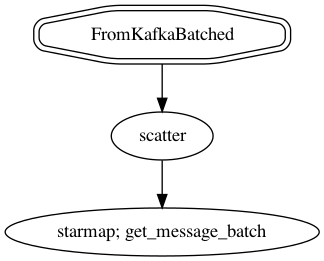

In [10]:
source.visualize()

In [11]:
outputs = []
h = source.map(json_loads).map(plus).buffer(5).gather().flatten().healing(interval = 5)
h.sink(outputs.append)

Output()

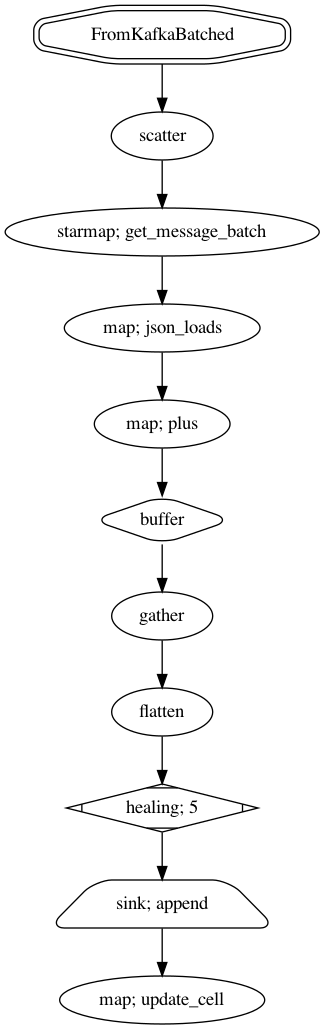

In [12]:
source.visualize()

In [13]:
source.start()

In [14]:
outputs

[]

In [15]:
from kafka import KafkaProducer
from kafka.partitioner import RoundRobinPartitioner

In [16]:
producer = KafkaProducer(
    bootstrap_servers = brokers.split(','),
    api_version = (0, 10),
    partitioner = RoundRobinPartitioner(),
)

INFO:kafka.conn:<BrokerConnection node_id=bootstrap-0 host=localhost:29092 <connecting> [IPv6 ('::1', 29092, 0, 0)]>: connecting to localhost:29092 [('::1', 29092, 0, 0) IPv6]
INFO:kafka.conn:<BrokerConnection node_id=bootstrap-0 host=localhost:29092 <connecting> [IPv6 ('::1', 29092, 0, 0)]>: Connection complete.


In [17]:
producer.bootstrap_connected()

True

In [18]:
from datetime import datetime
import json

def publish_message(producer_instance, topic_name, key, value):
    try:
        key_bytes = bytes(key, encoding = 'utf-8')
        value_bytes = bytes(value, encoding = 'utf-8')
        x = producer_instance.send(topic_name, value = value_bytes)
        return True
    except Exception as ex:
        print('Exception in publishing message')
        print(str(ex))
        return False

## purposely raise the error

Based on function `plus`, if input bigger than 30, it will throw error.

In [19]:
import time

for count in range(35):
    data = {'no': count, 'datetime': str(datetime.now())}
    print(data)
    publish_message(
        producer, 'testing', 'streaming', json.dumps(data)
    )
    time.sleep(0.1)

INFO:kafka.conn:<BrokerConnection node_id=1 host=localhost:29092 <connecting> [IPv6 ('::1', 29092, 0, 0)]>: connecting to localhost:29092 [('::1', 29092, 0, 0) IPv6]
INFO:kafka.conn:<BrokerConnection node_id=1 host=localhost:29092 <connecting> [IPv6 ('::1', 29092, 0, 0)]>: Connection complete.
INFO:kafka.conn:<BrokerConnection node_id=bootstrap-0 host=localhost:29092 <connected> [IPv6 ('::1', 29092, 0, 0)]>: Closing connection. 


{'no': 0, 'datetime': '2021-12-04 16:14:45.301423'}
{'no': 1, 'datetime': '2021-12-04 16:14:45.406486'}
{'no': 2, 'datetime': '2021-12-04 16:14:45.508234'}
{'no': 3, 'datetime': '2021-12-04 16:14:45.614839'}
{'no': 4, 'datetime': '2021-12-04 16:14:45.719305'}
{'no': 5, 'datetime': '2021-12-04 16:14:45.823619'}
{'no': 6, 'datetime': '2021-12-04 16:14:45.928222'}
{'no': 7, 'datetime': '2021-12-04 16:14:46.033002'}
{'no': 8, 'datetime': '2021-12-04 16:14:46.135938'}
{'no': 9, 'datetime': '2021-12-04 16:14:46.239380'}
{'no': 10, 'datetime': '2021-12-04 16:14:46.341781'}
{'no': 11, 'datetime': '2021-12-04 16:14:46.447615'}
{'no': 12, 'datetime': '2021-12-04 16:14:46.551487'}
{'no': 13, 'datetime': '2021-12-04 16:14:46.656630'}
{'no': 14, 'datetime': '2021-12-04 16:14:46.761748'}
{'no': 15, 'datetime': '2021-12-04 16:14:46.866857'}
{'no': 16, 'datetime': '2021-12-04 16:14:46.971997'}
{'no': 17, 'datetime': '2021-12-04 16:14:47.077473'}
{'no': 18, 'datetime': '2021-12-04 16:14:47.183051'}
{'n

INFO:root:healing successful: False, 2021-12-04 16:14:47.474084


{'no': 20, 'datetime': '2021-12-04 16:14:47.393282'}
{'no': 21, 'datetime': '2021-12-04 16:14:47.494286'}
{'no': 22, 'datetime': '2021-12-04 16:14:47.597641'}
{'no': 23, 'datetime': '2021-12-04 16:14:47.702870'}
{'no': 24, 'datetime': '2021-12-04 16:14:47.807234'}
{'no': 25, 'datetime': '2021-12-04 16:14:47.911566'}
{'no': 26, 'datetime': '2021-12-04 16:14:48.016768'}
{'no': 27, 'datetime': '2021-12-04 16:14:48.122562'}
{'no': 28, 'datetime': '2021-12-04 16:14:48.227322'}
{'no': 29, 'datetime': '2021-12-04 16:14:48.331609'}


INFO:root:{'function_name': 'FromKafkaBatched', 'data': "({'bootstrap.servers': 'localhost:29092', 'group.id': 'group-test-16', 'auto.offset.reset': 'latest', 'enable.auto.commit': False}, 'testing', 0, 104, 107, {'db': 0, 'username': None, 'password': None, 'socket_timeout': None, 'encoding': 'utf-8', 'encoding_errors': 'strict', 'decode_responses': False, 'retry_on_timeout': False, 'health_check_interval': 0, 'client_name': None, 'host': 'localhost', 'port': 6379, 'socket_connect_timeout': None, 'socket_keepalive': None, 'socket_keepalive_options': None})"}
INFO:root:{'function_name': 'scatter', 'data': '<Future: finished, type: builtins.tuple, key: tuple-8898587f0b56405eb6bd365ace48f592>'}


{'no': 30, 'datetime': '2021-12-04 16:14:48.434871'}
{'no': 31, 'datetime': '2021-12-04 16:14:48.537194'}
{'no': 32, 'datetime': '2021-12-04 16:14:48.639349'}
{'no': 33, 'datetime': '2021-12-04 16:14:48.743248'}


INFO:root:{'function_name': 'starmap.get_message_batch', 'data': '<Future: pending, key: apply-d5ea4566-5234-45b4-bab3-61c03041c846>'}
INFO:root:{'function_name': 'map.json_loads', 'data': '<Future: pending, key: json_loads--61800bb2-b373-482d-bdef-008686716ad0--bb6b07d5-ef27-4a79-a7e2-9a0d79cc3f0f>'}
INFO:root:{'function_name': 'map.plus', 'data': '<Future: pending, key: plus--61800bb2-b373-482d-bdef-008686716ad0--51a1f42d-fd43-40c4-8efb-075bd2d8f406>'}
INFO:root:{'function_name': 'buffer', 'data': '<Future: pending, key: plus--61800bb2-b373-482d-bdef-008686716ad0--51a1f42d-fd43-40c4-8efb-075bd2d8f406>'}
INFO:root:{'function_name': 'FromKafkaBatched', 'data': "({'bootstrap.servers': 'localhost:29092', 'group.id': 'group-test-16', 'auto.offset.reset': 'latest', 'enable.auto.commit': False}, 'testing', 1, 104, 106, {'db': 0, 'username': None, 'password': None, 'socket_timeout': None, 'encoding': 'utf-8', 'encoding_errors': 'strict', 'decode_responses': False, 'retry_on_timeout': False, 

{'no': 34, 'datetime': '2021-12-04 16:14:48.845970'}


In [20]:
from waterhealer.healing import get_memory

INFO:root:{'function_name': 'FromKafkaBatched', 'data': "({'bootstrap.servers': 'localhost:29092', 'group.id': 'group-test-16', 'auto.offset.reset': 'latest', 'enable.auto.commit': False}, 'testing', 2, 104, 106, {'db': 0, 'username': None, 'password': None, 'socket_timeout': None, 'encoding': 'utf-8', 'encoding_errors': 'strict', 'decode_responses': False, 'retry_on_timeout': False, 'health_check_interval': 0, 'client_name': None, 'host': 'localhost', 'port': 6379, 'socket_connect_timeout': None, 'socket_keepalive': None, 'socket_keepalive_options': None})"}
INFO:root:{'function_name': 'scatter', 'data': '<Future: finished, type: builtins.tuple, key: tuple-5220d46d5e0e4ffc98d9f843ea3129fc>'}
INFO:root:{'function_name': 'starmap.get_message_batch', 'data': '<Future: pending, key: apply-37f15318-a0ee-4a43-9b05-2c60dc963679>'}
INFO:root:{'function_name': 'map.json_loads', 'data': '<Future: pending, key: json_loads--37d91fbd-9007-4439-bb35-8150aa27b290--929652e3-c171-4de7-85a6-38f5d551009

INFO:root:{'function_name': 'map.json_loads', 'data': '<Future: pending, key: json_loads--7d1d0b81-b880-4da6-ac40-6a6c99d61a8a--62b4a4df-de86-4cb6-a9b4-3bd812de3e3b>'}
INFO:root:{'function_name': 'map.plus', 'data': '<Future: pending, key: plus--7d1d0b81-b880-4da6-ac40-6a6c99d61a8a--338bbc4f-d9c4-43dc-b678-77caa1908437>'}
INFO:root:{'function_name': 'FromKafkaBatched', 'data': "({'bootstrap.servers': 'localhost:29092', 'group.id': 'group-test-16', 'auto.offset.reset': 'latest', 'enable.auto.commit': False}, 'testing', 8, 78, 80, {'db': 0, 'username': None, 'password': None, 'socket_timeout': None, 'encoding': 'utf-8', 'encoding_errors': 'strict', 'decode_responses': False, 'retry_on_timeout': False, 'health_check_interval': 0, 'client_name': None, 'host': 'localhost', 'port': 6379, 'socket_connect_timeout': None, 'socket_keepalive': None, 'socket_keepalive_options': None})"}
INFO:root:{'function_name': 'gather', 'data': "[({'partition': 2, 'offset': 104, 'topic': 'testing'}, 3), ({'par

INFO:root:healing successful: True, 2021-12-04 16:14:52.606274
INFO:root:{'function_name': 'healing', 'data': "[{'topic': 'testing', 'partition': 0, 'offset': 104}, {'topic': 'testing', 'partition': 0, 'offset': 105}, {'topic': 'testing', 'partition': 0, 'offset': 106}, {'topic': 'testing', 'partition': 0, 'offset': 107}, {'topic': 'testing', 'partition': 1, 'offset': 104}, {'topic': 'testing', 'partition': 1, 'offset': 105}, {'topic': 'testing', 'partition': 1, 'offset': 106}, {'topic': 'testing', 'partition': 2, 'offset': 104}, {'topic': 'testing', 'partition': 2, 'offset': 105}, {'topic': 'testing', 'partition': 2, 'offset': 106}, {'topic': 'testing', 'partition': 3, 'offset': 104}, {'topic': 'testing', 'partition': 3, 'offset': 105}, {'topic': 'testing', 'partition': 3, 'offset': 106}, {'topic': 'testing', 'partition': 4, 'offset': 104}, {'topic': 'testing', 'partition': 4, 'offset': 105}, {'topic': 'testing', 'partition': 4, 'offset': 106}, {'topic': 'testing', 'partition': 5, 'of

INFO:root:healing successful: False, 2021-12-04 16:14:57.802519
INFO:root:healing successful: False, 2021-12-04 16:15:02.860316
INFO:root:healing successful: False, 2021-12-04 16:15:07.915166
INFO:root:healing successful: False, 2021-12-04 16:15:12.972389


In [21]:
_, consumer, memory = get_memory(source)
consumer

In [22]:
offsets = consumer.committed(consumer.assignment())
lags = {}
for offset in offsets:
    _, high_offset = consumer.get_watermark_offsets(offset)
    lags[offset.partition] = high_offset - offset.offset
lags

{}

In [23]:
memory.partitions

{'': <redis_collections.Dict at group-test-16- {}>,
 'testing<!>0': <redis_collections.Dict at group-test-16-testing<!>0 {}>,
 'testing<!>1': <redis_collections.Dict at group-test-16-testing<!>1 {107: 0}>,
 'testing<!>2': <redis_collections.Dict at group-test-16-testing<!>2 {107: 0}>,
 'testing<!>3': <redis_collections.Dict at group-test-16-testing<!>3 {107: 0}>,
 'testing<!>4': <redis_collections.Dict at group-test-16-testing<!>4 {107: 0}>,
 'testing<!>5': <redis_collections.Dict at group-test-16-testing<!>5 {}>,
 'testing<!>6': <redis_collections.Dict at group-test-16-testing<!>6 {}>,
 'testing<!>7': <redis_collections.Dict at group-test-16-testing<!>7 {}>,
 'testing<!>8': <redis_collections.Dict at group-test-16-testing<!>8 {}>,
 'testing<!>9': <redis_collections.Dict at group-test-16-testing<!>9 {}>}

INFO:root:healing successful: False, 2021-12-04 16:15:18.035541
INFO:root:healing successful: False, 2021-12-04 16:15:23.094135
INFO:root:healing successful: False, 2021-12-04 16:15:28.148359
INFO:root:healing successful: False, 2021-12-04 16:15:33.230329
INFO:root:healing successful: False, 2021-12-04 16:15:38.277788
INFO:root:healing successful: False, 2021-12-04 16:15:43.335195
INFO:root:healing successful: False, 2021-12-04 16:15:48.398366
INFO:root:healing successful: False, 2021-12-04 16:15:53.450941
INFO:root:healing successful: False, 2021-12-04 16:15:58.502206
INFO:root:healing successful: False, 2021-12-04 16:16:03.558151
INFO:root:healing successful: False, 2021-12-04 16:16:08.611441
INFO:root:healing successful: False, 2021-12-04 16:16:13.667119
INFO:root:healing successful: False, 2021-12-04 16:16:18.728172
INFO:root:healing successful: False, 2021-12-04 16:16:23.780963
INFO:root:healing successful: False, 2021-12-04 16:16:28.842115
INFO:root:healing successful: False, 202

INFO:root:healing successful: False, 2021-12-04 16:26:10.477014
INFO:root:healing successful: False, 2021-12-04 16:26:15.535571
INFO:root:healing successful: False, 2021-12-04 16:26:20.584458
INFO:root:healing successful: False, 2021-12-04 16:26:25.639186
INFO:root:healing successful: False, 2021-12-04 16:26:30.690880
INFO:root:healing successful: False, 2021-12-04 16:26:35.745279
INFO:root:healing successful: False, 2021-12-04 16:26:40.795906
INFO:root:healing successful: False, 2021-12-04 16:26:45.853403
INFO:root:healing successful: False, 2021-12-04 16:26:50.902516
INFO:root:healing successful: False, 2021-12-04 16:26:55.964658
INFO:root:healing successful: False, 2021-12-04 16:27:01.019482
INFO:root:healing successful: False, 2021-12-04 16:27:06.078916
INFO:root:healing successful: False, 2021-12-04 16:27:11.130883
INFO:root:healing successful: False, 2021-12-04 16:27:16.188667
INFO:root:healing successful: False, 2021-12-04 16:27:21.243996
INFO:root:healing successful: False, 202

INFO:root:healing successful: False, 2021-12-04 16:37:02.763310
INFO:root:healing successful: False, 2021-12-04 16:37:07.815243
INFO:root:healing successful: False, 2021-12-04 16:37:12.867007
INFO:root:healing successful: False, 2021-12-04 16:37:17.926700
INFO:root:healing successful: False, 2021-12-04 16:37:22.988262
INFO:root:healing successful: False, 2021-12-04 16:37:28.051064
INFO:root:healing successful: False, 2021-12-04 16:37:33.106025
INFO:root:healing successful: False, 2021-12-04 16:37:38.156764
INFO:root:healing successful: False, 2021-12-04 16:37:43.212893
INFO:root:healing successful: False, 2021-12-04 16:37:48.262424
INFO:root:healing successful: False, 2021-12-04 16:37:53.310092
INFO:root:healing successful: False, 2021-12-04 16:37:58.366512
INFO:root:healing successful: False, 2021-12-04 16:38:03.417711
INFO:root:healing successful: False, 2021-12-04 16:38:08.483974
INFO:root:healing successful: False, 2021-12-04 16:38:13.546802
INFO:root:healing successful: False, 202